# From Detection to Credibility: A Machine Learning Framework for Assessing News Source Reliability



In [1]:
# !pip3 install -r requirements.txt
# !pip3 install tensorflow
# !pip3 install gensim
!pip3 install scipy==1.10.1

ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.10.0 Requires-Python <3.12,>=3.8; 1.10.0rc1 Requires-Python <3.12,>=3.8; 1.10.0rc2 Requires-Python <3.12,>=3.8; 1.10.1 Requires-Python <3.12,>=3.8; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11; 1.9.0 Requires-Python >=3.8,<3.12; 1.9.0rc1 Requires-Python >=3.8,<3.12; 1.9.0rc2 Requires-Python >=3.8,<3.12; 1.9.0rc3 Requires-Python >=3.8,<3.12; 1.9.1 Requires-Python >=3.8,<3.12
ERROR: Could not find a version that satisfies the requirement scipy==1.10.1 (from versions:

In [6]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm

# Plotting and Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Language Detection packages
# `langdetect` for detecting language
from langdetect import detect as langdetect_detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
# `langid` for an alternative language detection method
from langid import classify as langid_classify

# Text Preprocessing and NLP
# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords
# Tokenizing sentences/words
from nltk.tokenize import word_tokenize
# Part-of-speech tagging
from nltk import pos_tag
# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer
import nltk
# Regular expressions for text pattern matching
import re

# Word Cloud generation
from wordcloud import WordCloud

# Count Vectoriser + Neural network


We first experiment with the use of a neural network for the classification task at hand.

We use a neural network for the following reasons:
#### Handling High-Dimensional Data: 
Neural networks are suited for handling high-dimensional data because they can learn complex patterns and relationships between features, such as text embeddings. This allows for the modelling of complex patterns between words or phrases.

#### Adaptability to Textual Nuances:
Neural networks can capture contextual information and nuances in text better than traditional models, which is crucial for accurately classifying fake news.

#### Enhanced Performance with Non-Linearities:
Neural networks can leverage non-linear fucntions (e.g., ReLU, sigmoid) to capture more intricate patterns in the data, allowing them to be able to discern subtle cues in language taht indicate misleading content.

Building upon our experiment using CNN, 

We use only 2 hidden layers with a dropout rate of 0.3 initially.
Additionally, the ADAM (Adaptive Moment Estimation) optimiser is used to adjust the weights to minimise the loss function (binary crossentropy for binary classification tasks).
Early stopping and L2 regularizer is implemented to prevent the tree from being overfitted.
Lastly, we set the number of epochs to 20, and allocate a batch size of 64.

In [6]:

# !pip install scikit-learn

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2

import tensorflow as tf
import random

# Set random seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Load data
data = pd.read_csv('processed_data.csv')

# Preprocess text data
use = data['processed_full_content'].apply(lambda x: x.lower())
vectorizer = CountVectorizer(max_features=5000)
X_vectorized = vectorizer.fit_transform(use).toarray()

# Create a mapping from word to index for the embedding layer
word_index = vectorizer.vocabulary_
vocab_size = len(word_index) + 1

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Store results for each fold
results = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

for train_index, test_index in kf.split(X_vectorized, data['label']):
    X_train, X_test = X_vectorized[train_index], X_vectorized[test_index]
    y_train, y_test = data['label'].iloc[train_index], data['label'].iloc[test_index]

    # Build the model
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=X_train.shape[1]))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',  
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model on the training data
    history = model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping],
                        verbose=1)
    
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append metrics to results dictionary
    results['accuracy'].append(accuracy)
    results['precision'].append(precision)
    results['recall'].append(recall)
    results['f1_score'].append(f1)

for metric in results:
    avg = np.mean(results[metric])
    std_dev = np.std(results[metric])
    print(f"{metric.capitalize()} - Average: {avg:.4f}, Standard Deviation: {std_dev:.4f}")

# Calculate and print average accuracy across all folds
average_accuracy = np.mean(results)
print(f'Average Test accuracy across all folds: {average_accuracy}')

c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
 45/799 ━━━━━━━━━━━━━━━━━━━━ 11:05 883ms/step - accuracy: 0.4721 - loss: 34.4915

KeyboardInterrupt: 

400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step


c:\Users\65840\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Neural network with CountVectorizer
Learning rate: 0.0010000000474974513
--------------------------------------------------
Loss Function:  binary_
--------------------------------------------------
Metrics:  ['loss', 'compile_metrics']
--------------------------------------------------
Layer dense_3 regularizer: L2
Layer dense_4 regularizer: L2
--------------------------------------------------
Accuracy: 0.5483870967741935
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


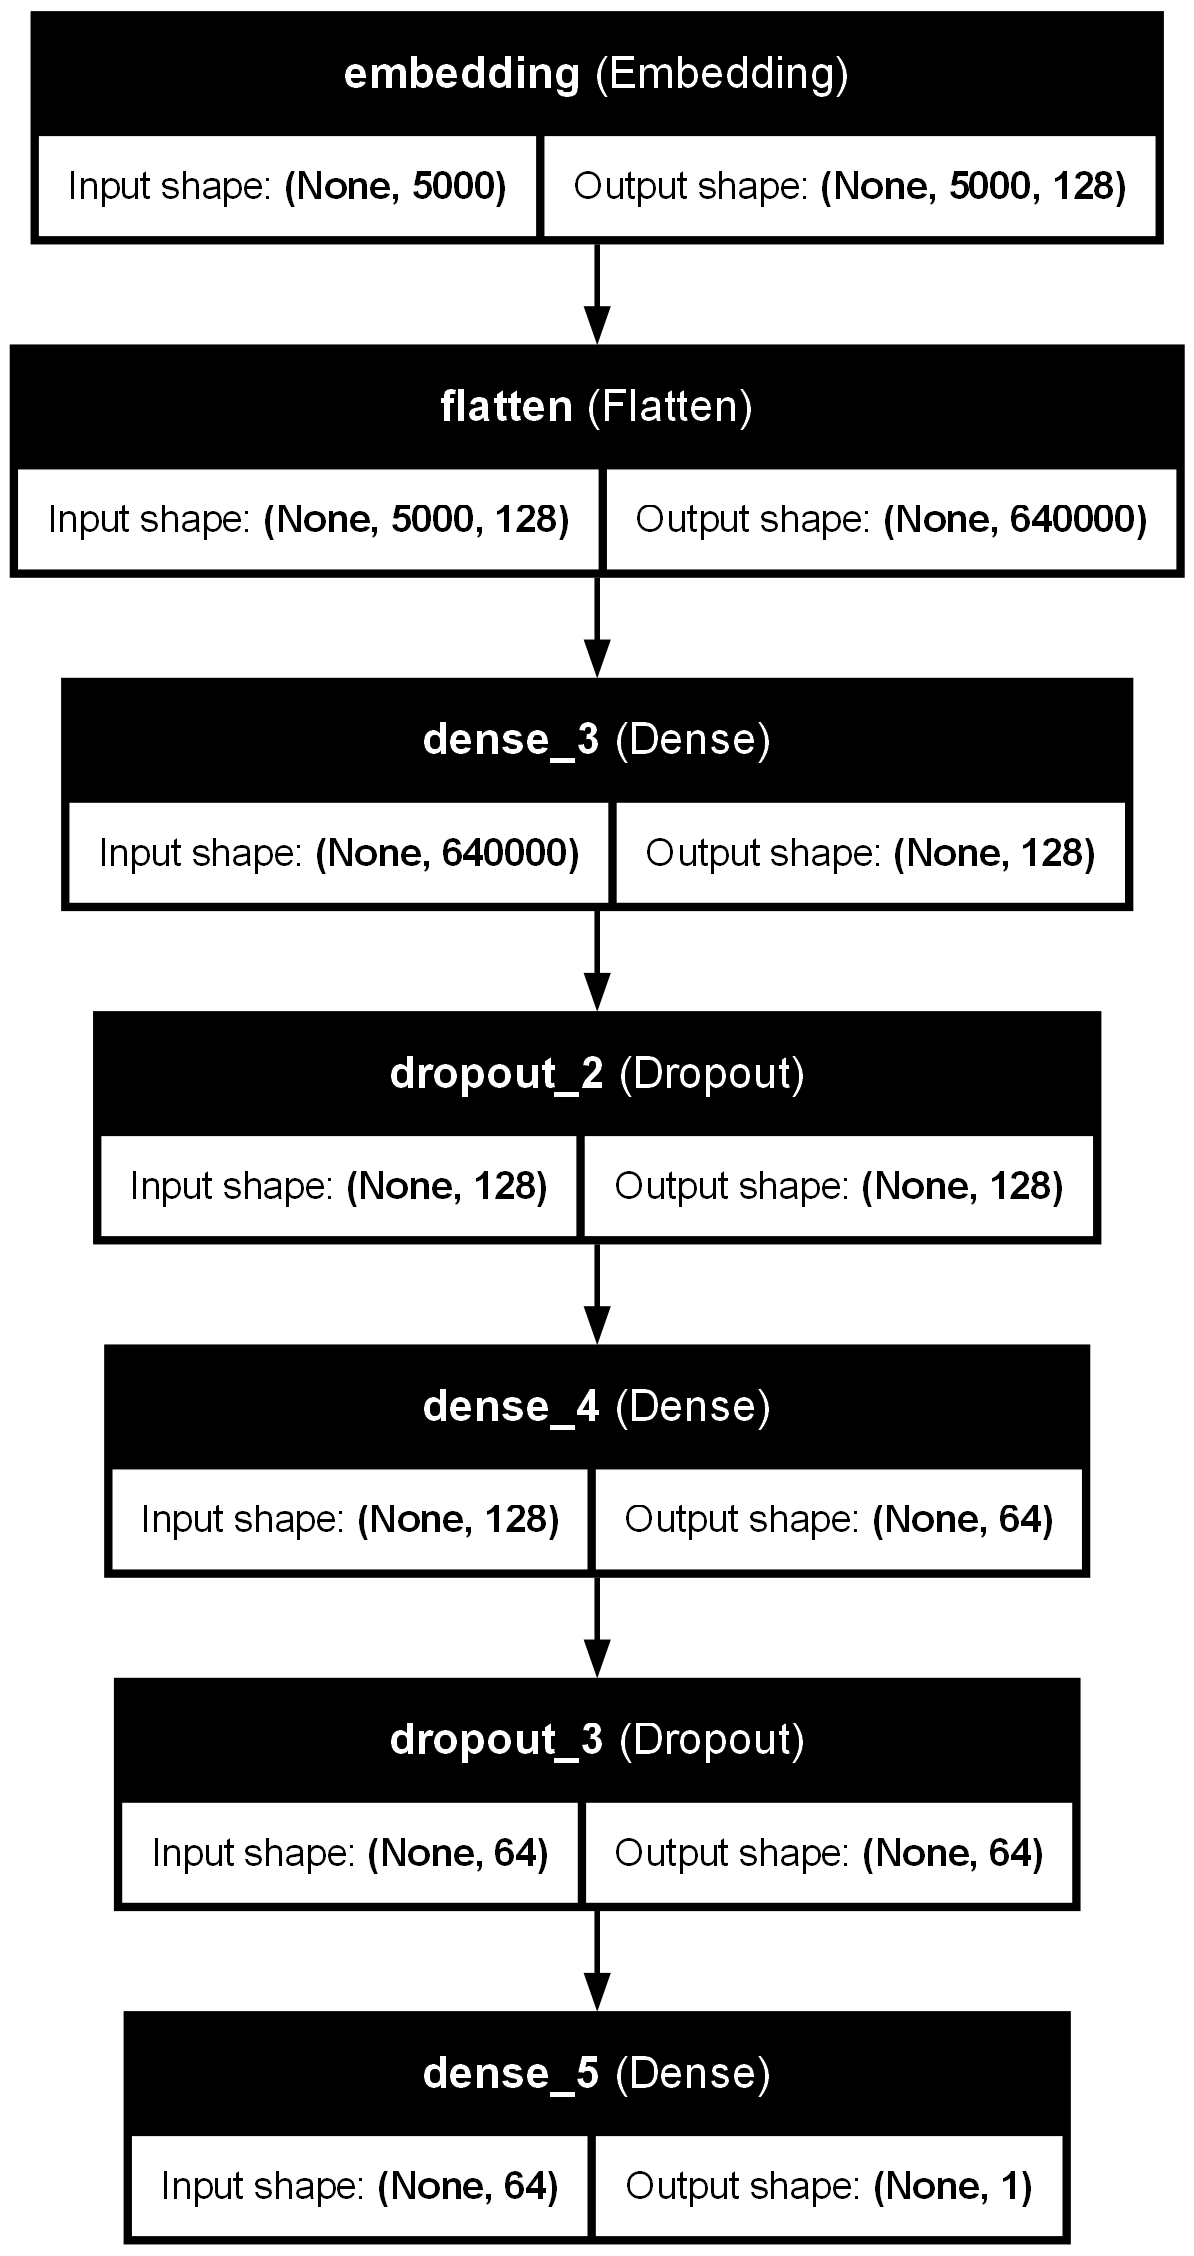

In [ ]:
# !pip3 install pydot
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


avg_accuracy = np.mean(results['accuracy'])
std_accuracy = np.std(results['accuracy'])

avg_precision = np.mean(results['precision'])
std_precision = np.std(results['precision'])

avg_recall = np.mean(results['recall'])
std_recall = np.std(results['recall'])

avg_f1 = np.mean(results['f1_score'])
std_f1 = np.std(results['f1_score'])

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model: Neural network with CountVectorizer")
print(f"Learning rate: {model.optimizer.learning_rate.numpy()}")
print("-" * 50)
print("Loss Function: ", model.loss[0:7])
print("-" * 50)
print("Metrics: ", model.metrics_names)
print("-" * 50)
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer is not None:
        print(f"Layer {layer.name} regularizer: {layer.kernel_regularizer.__class__.__name__}")
print("-" * 50)
print(f"Accuracy: {avg_accuracy:.5f}")
print(f"Precision: {avg_precision:.5f}")
print(f"Recall: {avg_recall:.5f}")
print(f"F1 Score: {avg_f1:.5f}")


plot_model(model, show_shapes=True, show_layer_names=True)

Though high, worth noting is the pre-processing method used. We chose count vectorizer to investigate its effectiveness, However, more modern methods to represent text data have been developed over the years. The next method we will consider is Word2Vec, a word embedding technique. One of its most distinctive feature that sets it apart from count vectoriser is its ability to capture semantic relationships between words, allowing the model to better understand the context and meaning within strings of text.

Furthermore, word embeddings are also usually lower-dimensional and less dense vectors, making them more computationally efficient.

In [3]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, GlobalAveragePooling1D
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Load your data
# data = pd.read_csv('processed_data.csv')  # Uncomment this line to load your data
second_run = data['processed_full_content']
labels = data['label'].values

# Tokenization and preparing sentences for Word2Vec training
sentences = [sentence.lower().split() for sentence in second_run]

# Step 2: Train Word2Vec embeddings
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create a vocabulary mapping from word to index
word_index = {word: i for i, word in enumerate(model_w2v.wv.index_to_key)}

# Initialize the embedding matrix with zeros
embedding_dim = model_w2v.wv.vector_size  # Dimension of the embedding vectors
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = model_w2v.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Assign the vector to the embedding matrix

# Convert sentences to sequences of integers based on word indices
sequences = [[word_index[word] for word in sentence if word in word_index] for sentence in sentences]
# Pad sequences to ensure uniform input size (e.g., max length of 100)
X = pad_sequences(sequences, maxlen=100)
y = labels 

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results for each fold
results = []
accuracies = []
precisions = []
recalls = []
f1_scores = []


for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Step 6: Build the neural network
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=100,
                        trainable=False))  # Set trainable=True if you want to fine-tune embeddings

    model.add(GlobalAveragePooling1D())  # Optional pooling layer 
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping],
                        verbose=0)  # Set verbose to 0 to suppress output

    # Evaluate the model on the test set and store results
    loss, accuracy = model.evaluate(X_test, y_test)
    results.append(accuracy)
    print(f'Test accuracy for current fold: {accuracy:.4f}')

    y_pred_prob = model.predict(X_test) 
    y_pred = (y_pred_prob > 0.5).astype(int)  

    # Calculate Accuracy, Precision, Recall, and F1 Score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append the metrics to their respective lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Calculate and print average accuracy across all folds
average_accuracy = np.mean(results)
print(f'Average Test accuracy across all folds: {average_accuracy:.4f}')



c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9151 - loss: 0.2676
Test accuracy for current fold: 0.9166
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9126 - loss: 0.2721
Test accuracy for current fold: 0.9124
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9166 - loss: 0.2586
Test accuracy for current fold: 0.9171
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9072 - loss: 0.2843
Test accuracy for current fold: 0.9118
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.9158 - loss: 0.2665
Test accuracy for current fold: 0.9153
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Average Test accuracy across all folds: 0.9146


Model: Neural network with Word2Vec
Learning rate: 0.0010000000474974513
--------------------------------------------------
Loss Function:  binary_
--------------------------------------------------
Metrics:  ['loss', 'compile_metrics']
--------------------------------------------------
Layer dense_30 regularizer: L2
Layer dense_31 regularizer: L2
--------------------------------------------------
Average Accuracy: 0.91463
Average Precision: 0.90596
Average Recall: 0.90681
Average F1 Score: 0.90631


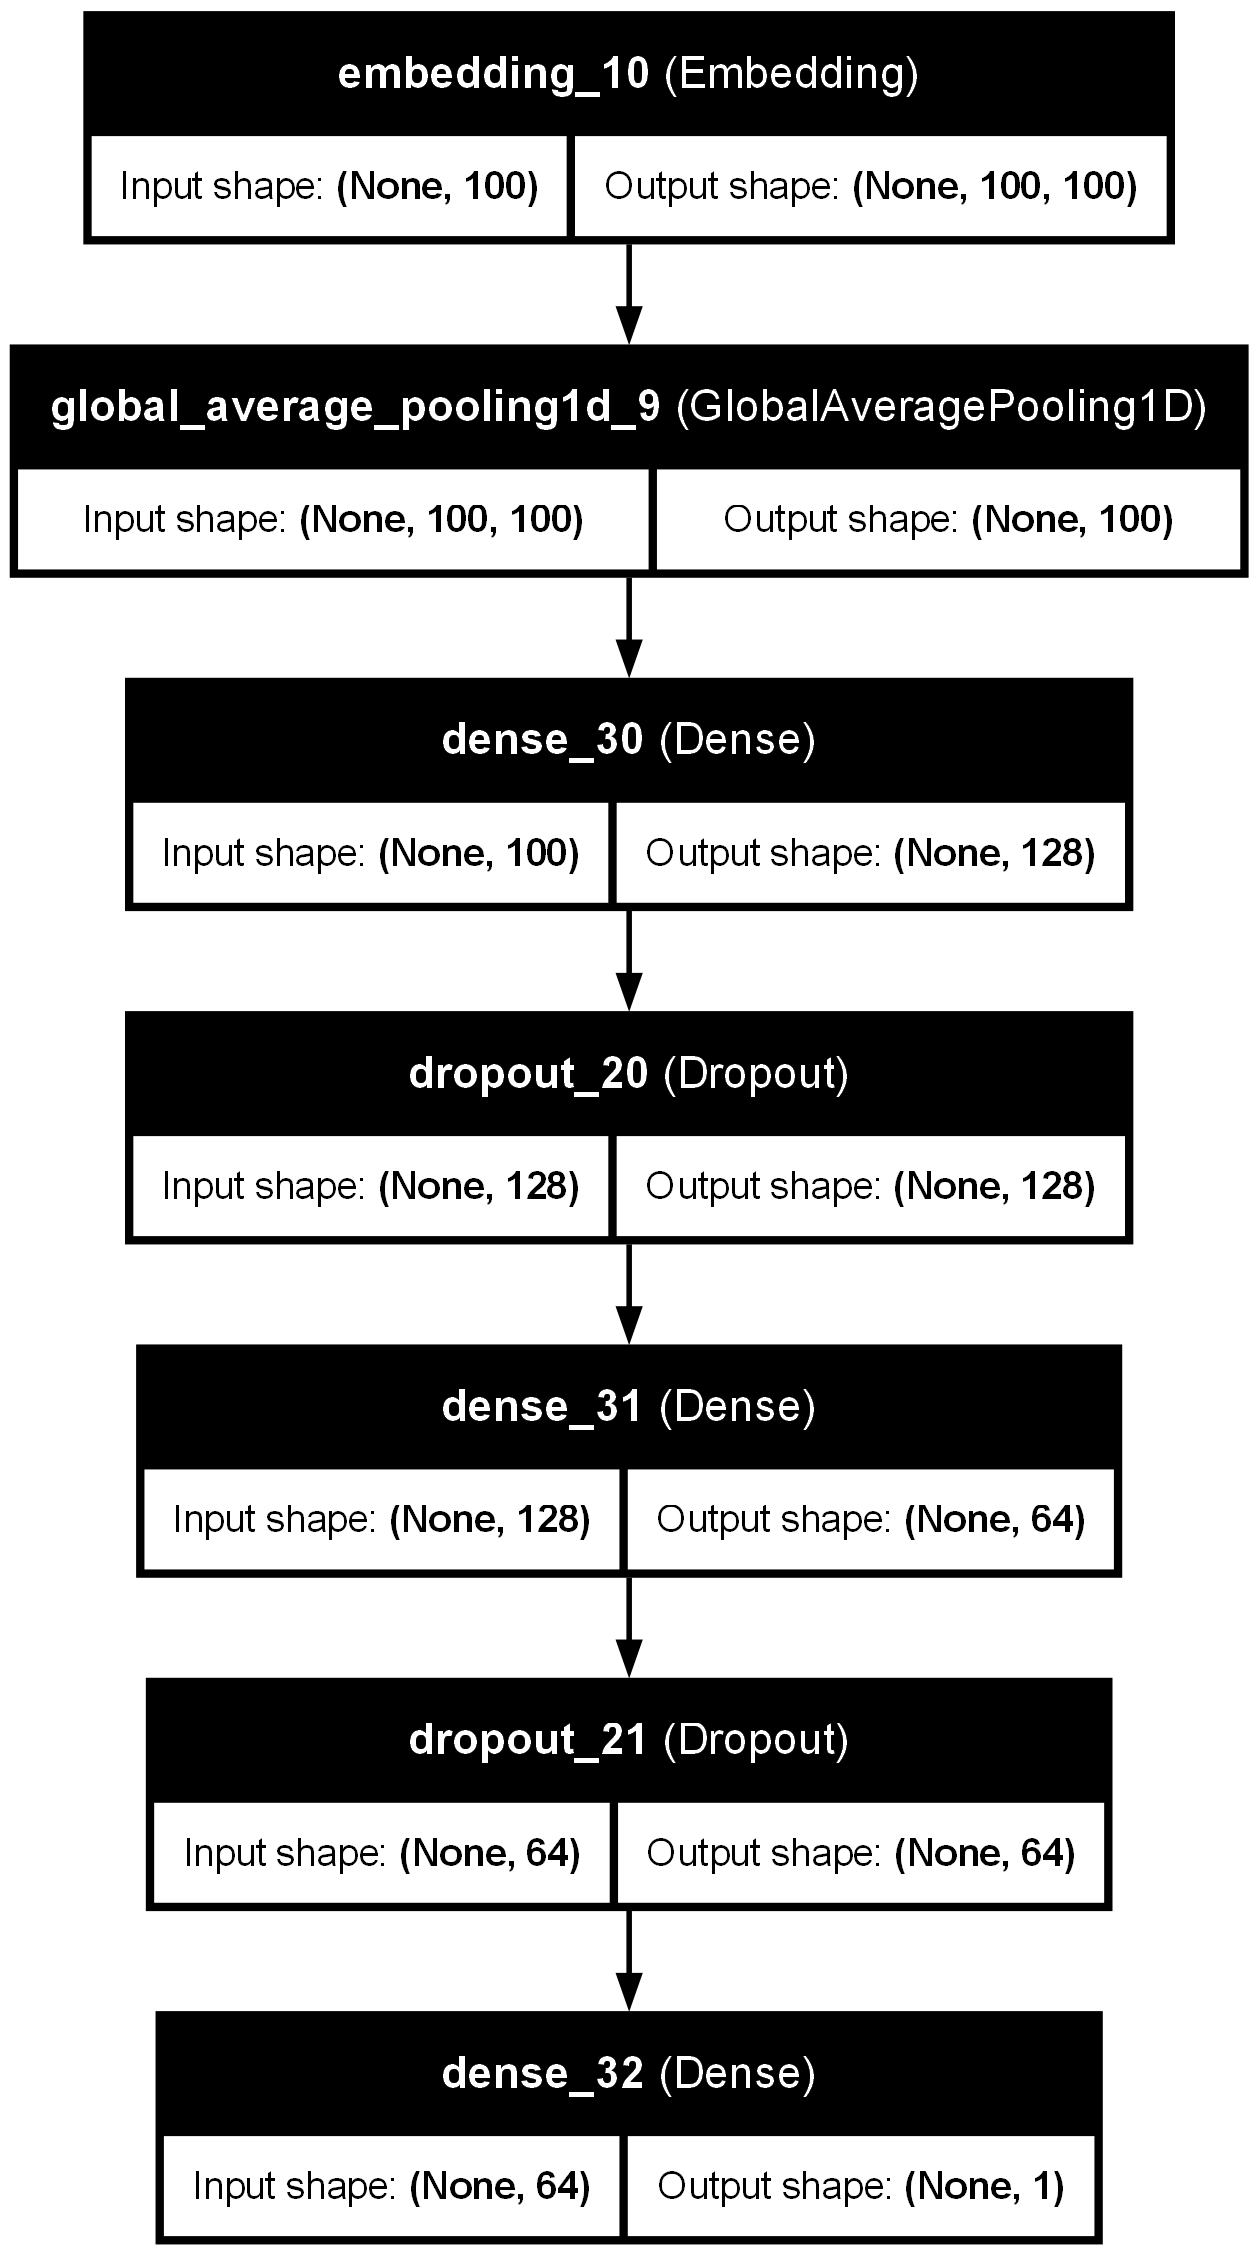

In [5]:
from tensorflow.keras.utils import plot_model

avg_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

avg_precision = np.mean(precisions)
std_precision = np.std(precisions)

avg_recall = np.mean(recalls)
std_recall = np.std(recalls)

avg_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)  

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model: Neural network with Word2Vec")
print(f"Learning rate: {model.optimizer.learning_rate.numpy()}")
print("-" * 50)
print("Loss Function: ", model.loss[0:7])
print("-" * 50)
print("Metrics: ", model.metrics_names)
print("-" * 50)

for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer is not None:
        print(f"Layer {layer.name} regularizer: {layer.kernel_regularizer.__class__.__name__}")
print("-" * 50)

# Print summarized statistics with standard deviations
print(f"Average Accuracy: {avg_accuracy:.5f}")
print(f"Average Precision: {avg_precision:.5f}")
print(f"Average Recall: {avg_recall:.5f}")
print(f"Average F1 Score: {avg_f1:.5f}")

# Optionally plot the model architecture
plot_model(model, show_shapes=True, show_layer_names=True)

# Using k-fold partitioning to achieve better results

As we have learnt from our experiment with CNN, using count vectorizer/tf-idf will result in the the model being unable to capture language patterns and word associations since each term is treated as an independent vector (thus not being context aware). Subsequently, we will explore the performance of the model when GloVe is used for the pre-processing instead.

Developed after Word2Vec, it works on the idea of using leveraging a global context(across the corpus) rather than merely a local one (i.e. neighbouring words). 
Some advantages over word2vec include: 
- models relationship between words explicitly, allowing for potentially more interpretable semantic relationships
- more stable and efficientapporach that is less sensitive to hyperparameters
- robust across tasks, especially when understanding global context is crucial

Additionally, we will use the same k-fold partitioning method as the CNN experiment.

In [11]:

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [18]:
from keras.preprocessing.sequence import pad_sequences


data = pd.read_csv('processed_data.csv')
k_fold_var = data['processed_full_content'].copy()
y = data['label'].values

# Parameters used
dropout = 0.3
layer_1 = 128
layer_2 = 64

# Load GloVe embeddings
embeddings_index = {}
with open('./glove.6B.100d.txt', 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create a vocabulary mapping from word to index
word_index = {word: i + 1 for i, word in enumerate(embeddings_index.keys())}  # +1 for padding (0 index is reserved)

# Create an embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))  # +1 for padding index
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Prepare input data for Keras model (convert text to sequences of indices)
def text_to_sequence(text):
    # Convert text to lowercase and split into words
    words = text.lower().split()
    # Convert words to their corresponding indices, using 0 for unknown words
    return [word_index.get(word, 0) for word in words]  # 0 is used for OOV (out-of-vocabulary) words

# print(k_fold_var.head())

# Convert texts to sequences and pad them directly
X_sequences = [text_to_sequence(text) for text in k_fold_var]
max_length = 100  # Adjust based on your dataset's average sentence length
X_padded = pad_sequences(X_sequences, maxlen=max_length)

# Stratified K-Fold Cross Validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the model with an embedding layer
def create_model(input_shape):
    model = Sequential([
        Embedding(input_dim=len(word_index) + 1,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=input_shape,
                  trainable=False),  # Set trainable=True if you want to fine-tune embeddings
        Flatten(),
        Dense(layer_1, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout),
        Dense(layer_2, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Store metrics
acc_scores, prec_scores, recall_scores, f1_scores = [], [], [], []

for train_index, test_index in skf.split(X_padded, y):
    X_train, X_test = X_padded[train_index], X_padded[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

    # Predictions and Metrics
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    acc_scores.append(accuracy_score(y_test, y_pred))
    prec_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Print average scores across folds
print(f'Accuracy: {np.mean(acc_scores):.4f}')
print(f'Precision: {np.mean(prec_scores):.4f}')
print(f'Recall: {np.mean(recall_scores):.4f}')
print(f'F1 Score: {np.mean(f1_scores):.4f}')



c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\65840\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8850
Precision: 0.8657
Recall: 0.8868
F1 Score: 0.8753


Stratified K-fold with GloVe
Learning rate: 0.0010000000474974513
--------------------------------------------------
Loss Function:  binary_
--------------------------------------------------
Metrics:  ['loss', 'compile_metrics']
--------------------------------------------------
Layer dense_39 regularizer: L2
Layer dense_40 regularizer: L2
--------------------------------------------------
Average Accuracy: 0.87161
Average Precision: 0.86268
Average Recall: 0.86125
Average F1 Score: 0.85966


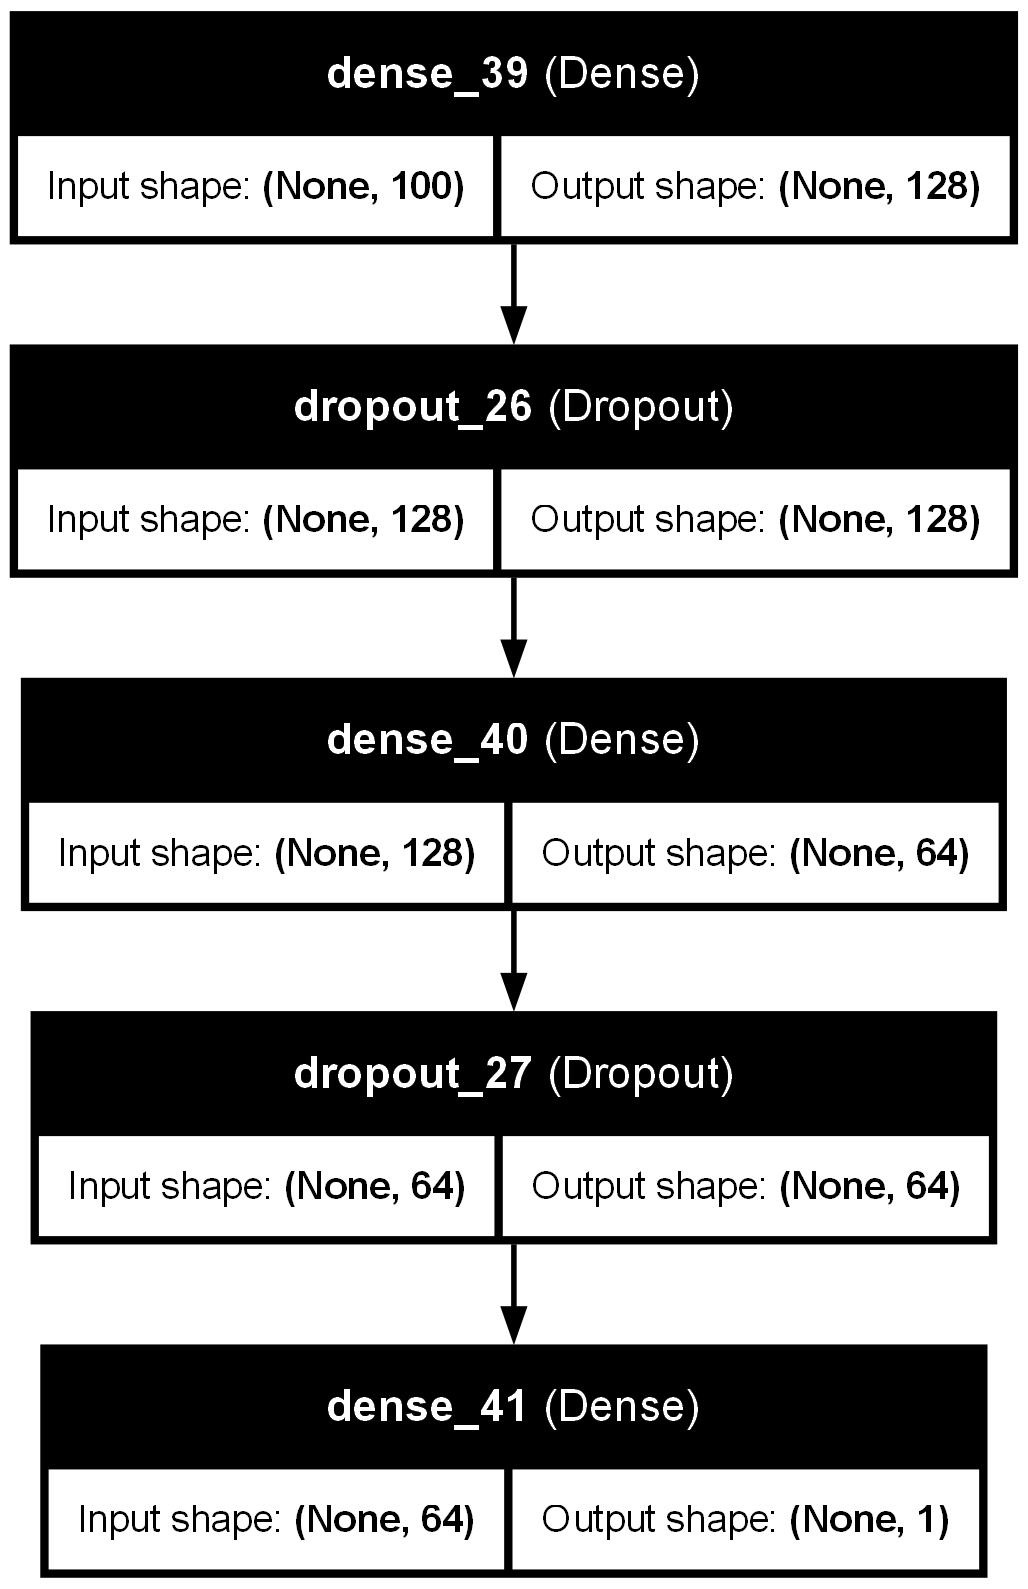

In [ ]:
print(f"Stratified K-fold with GloVe")

print(f"Learning rate: {model.optimizer.learning_rate.numpy()}")
print("-"*50)
print("Loss Function: ", model.loss[0:7])
print("-"*50)
print("Metrics: ", model.metrics_names)
print("-"*50)
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer is not None:
        print(f"Layer {layer.name} regularizer: {layer.kernel_regularizer.__class__.__name__}")
print("-"*50)

print(f"Average Accuracy: {np.mean(acc_scores):.5f}")
print(f"Average Precision: {np.mean(prec_scores):.5f}")
print(f"Average Recall: {np.mean(recall_scores):.5f}")
print(f"Average F1 Score: {np.mean(f1_scores):.5f}")


plot_model(model, show_shapes=True, show_layer_names=True)